# Time Series Analysis on Fortune 500 Ecommerce Product Data

In this project, I will use Sarimax method along with RNN to do time series analysis of an Ec

In [1]:
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import itertools
import warnings
import math
import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# SARIMA Functions

In [2]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test for product:',m)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)   

In [3]:
# Finding best paramters ir is AutoCorrelation, Partial auto correlation factors etc
def FindBestParameters(temp):
    # Define the d and q parameters to take any value between 0 and 1
    best_param=[]
    best_param_seasonal=[]
    best_result=[]
    q = d = range(0, 1)
    # Define the p parameters to take any value between 0 and 3
    p = range(0, 2)

    # Generate all different combinations of p, q and d triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and d triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    warnings.filterwarnings("ignore") # specify to ignore warning messages

    AIC = []
    SARIMAX_model = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(temp,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
                best_param, best_param_seasonal, best_result = param, param_seasonal, results.aic
                if results.aic < best_result:
                    best_result = results.aic
                    best_param = param
                    best_param_seasonal = param_seasonal
            except:
                continue
    print ('Best {},{},{}'.format(best_param, best_param_seasonal, best_result))
    return(best_param,best_param_seasonal)

In [4]:
## Using the best paramters to implement Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
def model(param,param_seasonal):
    mdl = sm.tsa.statespace.SARIMAX(temp,
                                order=(param[0], param[1], param[2]),
                                seasonal_order=(param_seasonal[0], param_seasonal[1], param_seasonal[2], param_seasonal[3]),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
    res = mdl.fit()
    res.plot_diagnostics(figsize=(16, 10))
    plt.tight_layout()
    plt.show()
    return(res)

In [5]:
## Fitting our model and seeing how our estimates and fit looks like
    
def fit(res):
    pred = res.get_prediction(start=pd.to_datetime('2016-06-30'), dynamic=False)
    pred.predicted_mean=pred.predicted_mean+1
    pred_ci = pred.conf_int()
    ax = y['2014':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('$ Amount(1000) for Product')
    plt.legend()

    plt.show()
    return(pred)

In [6]:
## Out of sample forcasting using ARIMA

def predict(pred,res,y):
    y_forecasted = pred.predicted_mean
    y_truth = y['2017-10-20':]

    # Compute the mean square error
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    pred_uc = res.get_forecast(steps=73)
    pred_uc.predicted_mean.plot()
    plt.show()
    return(pred_uc.predicted_mean)

# KERAS DEEP LEARNING RNN MODEL Function definations

In [7]:
#Getting Data and transforming it into standardized format
def getdata(m):
    values = df[m].values.reshape(-1,1)
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    train_size = int(len(scaled) * 0.7)
    test_size = len(scaled) - train_size
    train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
    return(train,test,scaler)

In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [9]:
#Reshaping our data for processing
def reshape_data(train,test):
    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    return(trainX,testX,trainY,testY)

In [10]:
#Implementing a Deep Neural Network model
def NN_model(trainX,testX):
    model = Sequential()
    model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
    return(history,model)

In [11]:
#Plotting Train vs test loss function
def plotTrain_Test(history,model):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    yhat = model.predict(testX)
    return(yhat)

In [12]:
#Finding MSE of Neural Network model
def FindMSE(yhat,testY,scaler):
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
    mse = mean_squared_error(testY_inverse, yhat_inverse)
    print('Test MSE: %.3f' % mse)
    return(yhat_inverse,testY_inverse)

In [13]:
#Plotting Actual vs Predicted value using plotly 
def ActualvsPredicted(testX,yhat_inverse,testY_inverse):
    predictDates = df.tail(len(testX)).Date
    testY_reshape = testY_inverse.reshape(len(testY_inverse))
    yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))
    actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
    predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
    py.iplot([predict_chart, actual_chart])

## Starting from here we build our model

In [14]:
#Loading Dataset
df=pd.read_csv("ADM_problem_set_dataset.csv",parse_dates=['Date'])
df.head()

,Date,0,1,2,3,4,5,6,7,8,...,418,419,420,421,422,423,424,425,426,427
0,2014-10-22,0.801904,0.029146,0.095752,0.003619,0.241878,2.535904,4.240986,0.038281,0.310240,...,0.244417,1.568204,0.180691,0.547740,0.621678,0.371033,0.366755,0.999874,0.957433,0.000000
1,2014-10-23,1.117338,0.000000,0.089933,0.000000,0.222267,2.599584,4.358325,0.043066,0.306067,...,0.209500,1.567310,0.180691,0.452783,0.631193,0.437978,0.334989,1.460067,1.003781,0.016562
2,2014-10-24,1.216875,0.041942,0.087552,0.027341,0.226625,2.532743,4.282893,0.032433,0.340847,...,0.137339,1.300724,0.197117,0.507209,0.656568,0.443652,0.359054,1.376395,0.982594,0.039147
3,2014-10-27,1.296785,0.066823,0.116384,0.037795,0.222267,2.640683,4.249367,0.061675,0.378410,...,0.202517,1.310564,0.193010,0.531528,0.723176,0.433440,0.343652,1.418231,0.986566,0.066248
4,2014-10-28,1.317814,0.071089,0.239645,0.084838,0.235341,2.717911,4.148790,0.000000,0.470229,...,0.307267,1.354398,0.203278,0.525738,0.910314,0.574138,0.397558,1.676566,1.083237,0.102384


#### We will see two major things here, we will find how many columns have missing values, and if our time series is consistant on dates.

In [15]:
null_columns=df.columns[df.isnull().any()]

#Percentage of missing value in each column
df[null_columns].isnull().sum()/len(df)*100

64     69.576720
109    35.582011
147     0.132275
170    56.481481
193    32.936508
231    23.148148
252     0.132275
304    23.148148
327     6.481481
387    23.544974
414    22.222222
dtype: float64

In [16]:
df.Date.diff().max()

Timedelta('4 days 00:00:00')

### Preprocssing for Timeseries

We can see that our dates are not consistant and there are many missing values, so we will impute all the missing dates and fill in the values of the missing dates using **"ffil"** method as logically in time series, each n+1 value doesnt differ from n value that much. Hence we will impute n+1 value for each missing n values.

In [17]:
df_2=df.set_index("Date")

In [18]:
start = df_2.index.min()
end = df_2.index.max()

In [19]:
index = pd.date_range(start,end,freq="D")

#Adding missing indexes
df_2 = df_2.reindex(index)

In [20]:
df_2=df_2.interpolate()

In [21]:
df_2.shape

(1095, 428)

#### Lets find the top product by summing up total sales made till date by each product. Also, we have to be careful about one thing, some of the products shows that they have been added in later years such as product "304", "387" etc, so for the sake of fairness we will compute total sale of each product from the day these new product were added.

In [22]:
df_3=df_2.dropna(how='any')

In [23]:
null_columns=df_3.columns[df_3.isnull().any()]
df_3[null_columns].isnull().sum()

Series([], dtype: float64)

In [24]:
top5=df_3.sum().nlargest(5)
top5

313    1971.910304
415    1891.405485
244    1881.746390
104    1845.646457
236    1812.488857
dtype: float64

In [25]:
df_2=df_2.reset_index()

Filtering out our top 5 products

In [26]:
data=df_2.filter(items=['index','313', '415','244','104','236'])

In [27]:
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum()

Series([], dtype: float64)

## Time Series Plot for Top 5 Products

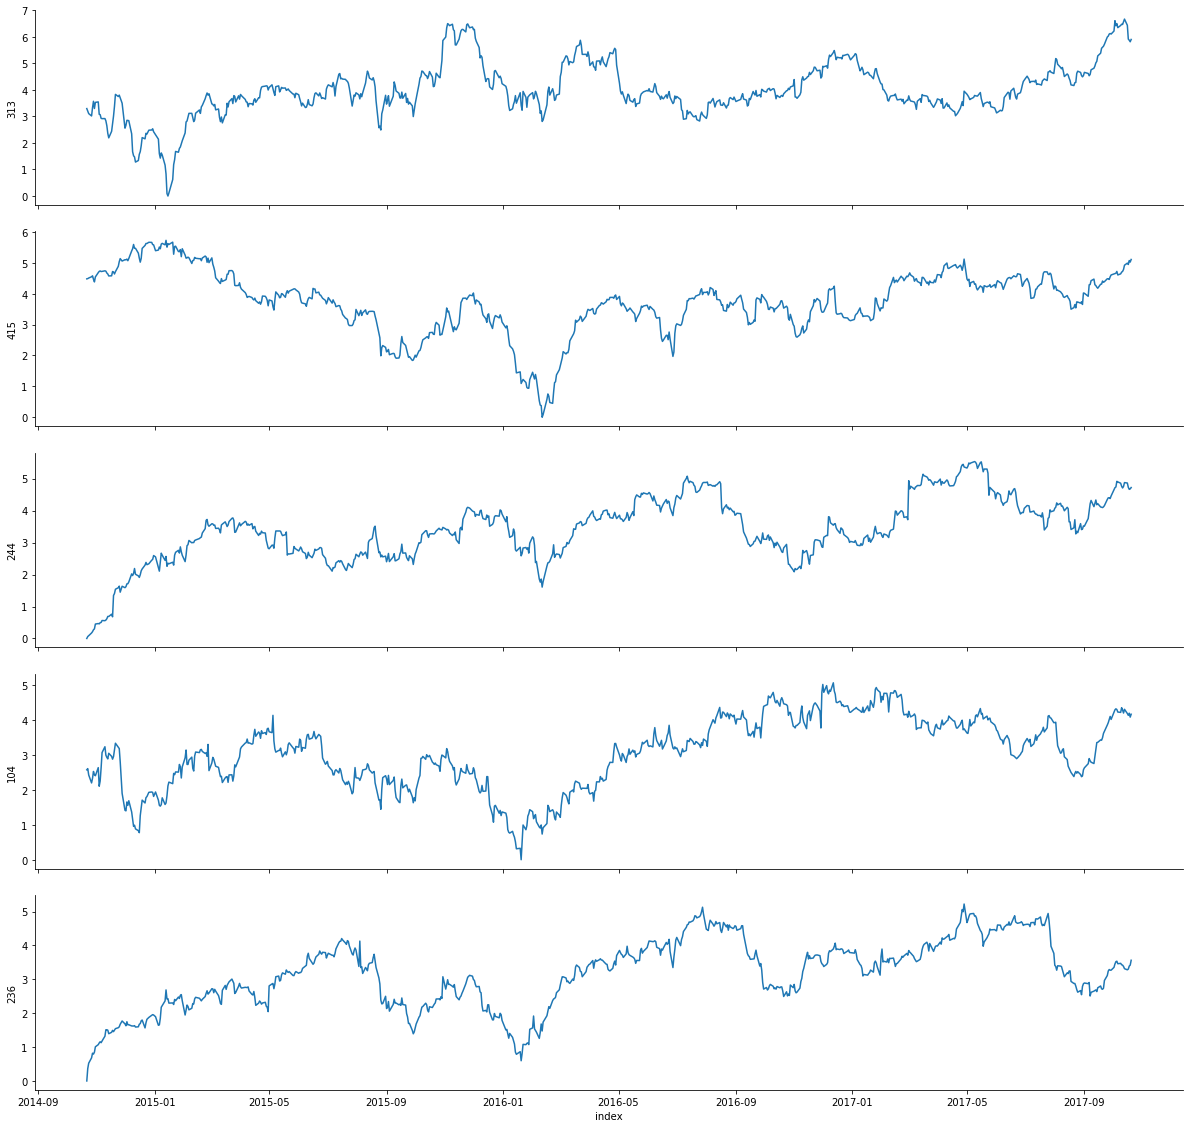

In [28]:
g = sns.PairGrid(data, y_vars=['313', '415','244','104','236'], x_vars='index')  
fig = plt.gcf()
fig.set_size_inches(26, 16)
g = g.map(plt.plot)

In [29]:
columns=['313', '415','244','104','236']

## Rolling Mean and Rolling STD plot for Top 5 Products

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



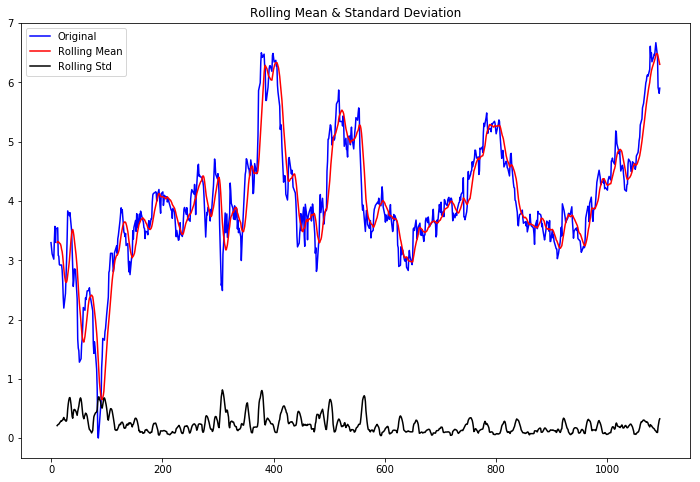

Results of Dickey-Fuller Test for product: 313
Test Statistic                   -3.166386
p-value                           0.022015
#Lags Used                        3.000000
Number of Observations Used    1091.000000
Critical Value (1%)              -3.436358
Critical Value (5%)              -2.864193
Critical Value (10%)             -2.568182
dtype: float64


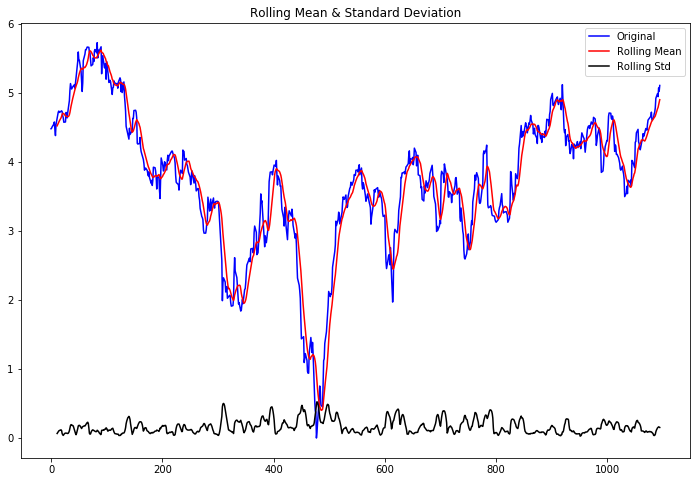

Results of Dickey-Fuller Test for product: 415
Test Statistic                   -2.036383
p-value                           0.270852
#Lags Used                        1.000000
Number of Observations Used    1093.000000
Critical Value (1%)              -3.436347
Critical Value (5%)              -2.864188
Critical Value (10%)             -2.568180
dtype: float64


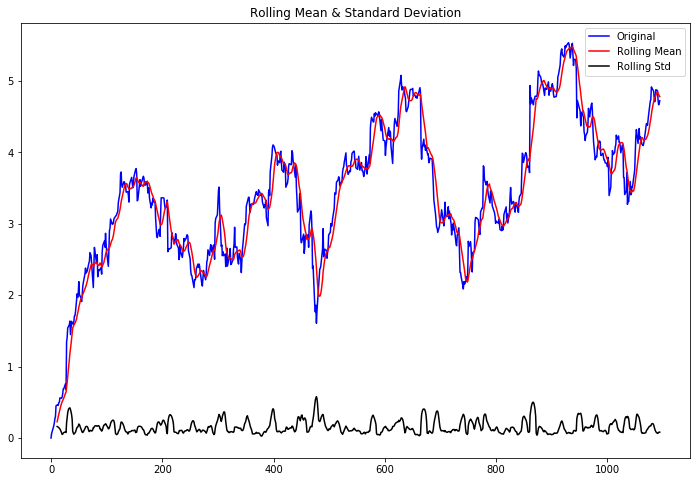

Results of Dickey-Fuller Test for product: 244
Test Statistic                   -3.269155
p-value                           0.016315
#Lags Used                        1.000000
Number of Observations Used    1093.000000
Critical Value (1%)              -3.436347
Critical Value (5%)              -2.864188
Critical Value (10%)             -2.568180
dtype: float64


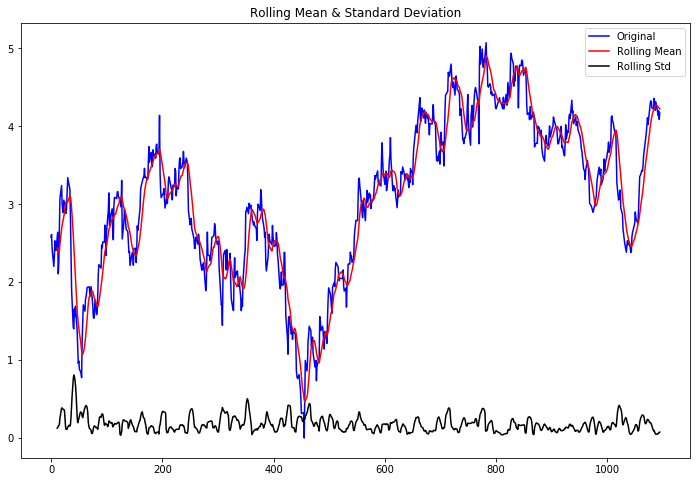

Results of Dickey-Fuller Test for product: 104
Test Statistic                   -2.214477
p-value                           0.201033
#Lags Used                        2.000000
Number of Observations Used    1092.000000
Critical Value (1%)              -3.436353
Critical Value (5%)              -2.864190
Critical Value (10%)             -2.568181
dtype: float64


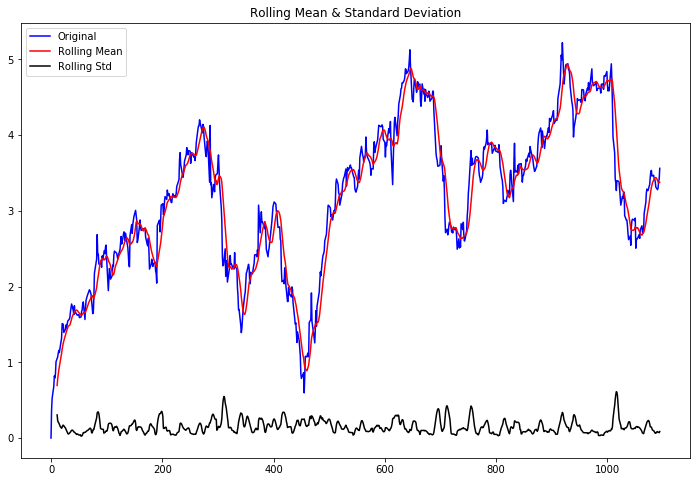

Results of Dickey-Fuller Test for product: 236
Test Statistic                   -2.935874
p-value                           0.041333
#Lags Used                        1.000000
Number of Observations Used    1093.000000
Critical Value (1%)              -3.436347
Critical Value (5%)              -2.864188
Critical Value (10%)             -2.568180
dtype: float64


In [30]:
for m in columns:
    try:
        test_stationarity(data[m])
    except:
        continue   

## Result for our experiment

We will start calling the functions we made at the start of this lab. We will pass everything using loop and calculate the forcasted values of each product.

Stats for product 313
Best (1, 0, 0),(1, 0, 0, 12),-1018.819513513579135135791


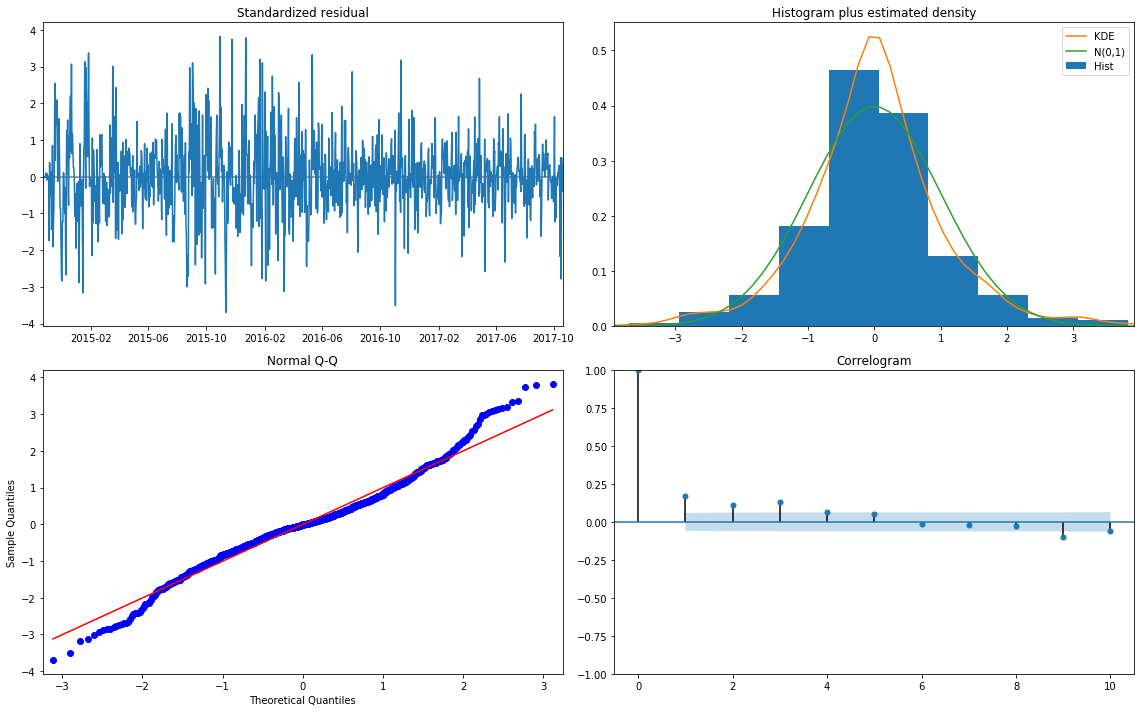

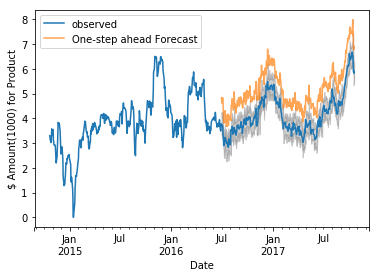

The Mean Squared Error of our forecasts is 0.88


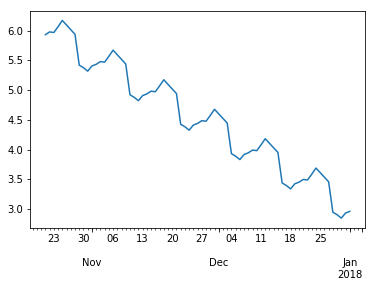

Forcasted $ Values for product  313 are : 2017-10-21    5.931132
2017-10-22    5.977431
2017-10-23    5.967799
2017-10-24    6.066170
2017-10-25    6.170327
Freq: D, dtype: float64




Stats for product 415
Best (1, 0, 0),(1, 0, 0, 12),-1714.330633873098838730988


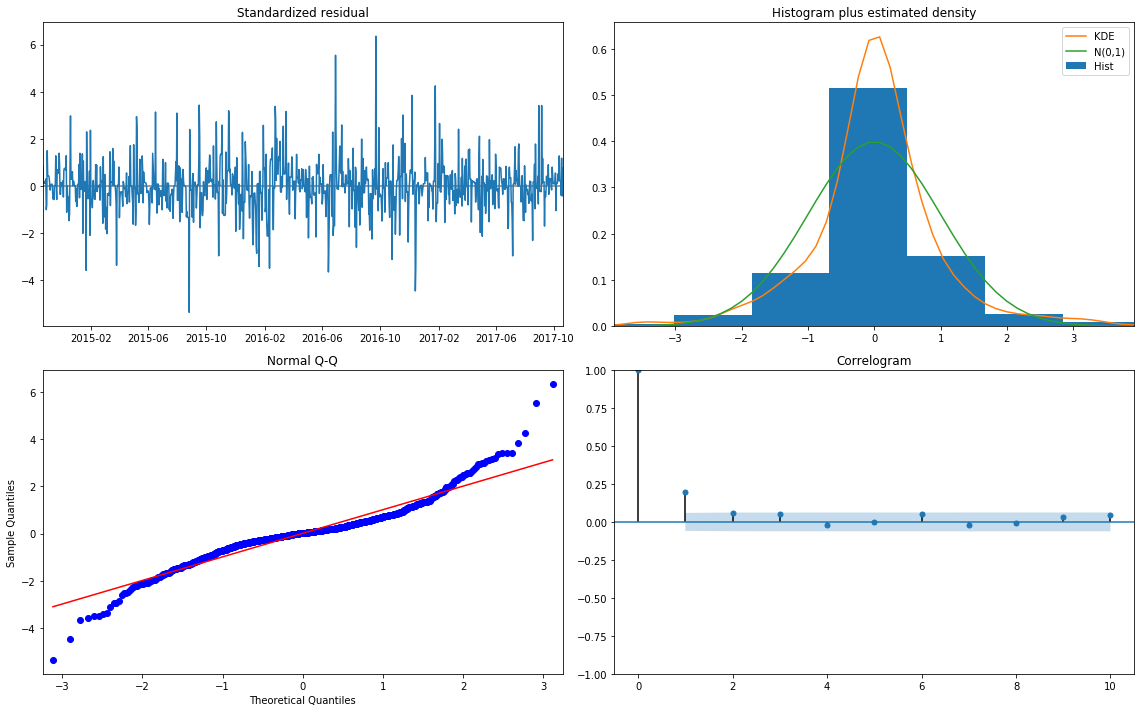

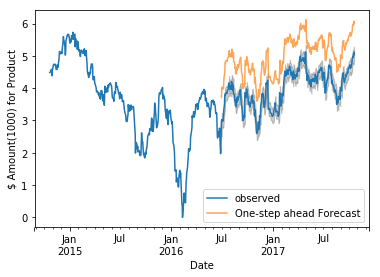

The Mean Squared Error of our forecasts is 0.84


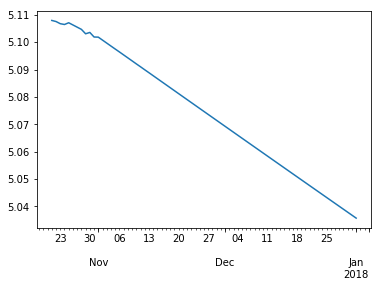

Forcasted $ Values for product  415 are : 2017-10-21    5.108006
2017-10-22    5.107610
2017-10-23    5.106822
2017-10-24    5.106525
2017-10-25    5.107158
Freq: D, dtype: float64




Stats for product 244
Best (1, 0, 0),(1, 0, 0, 12),-1548.379829501841995018419
Stats for product 104
Best (1, 0, 0),(1, 0, 0, 12),-1210.016532637118426371184


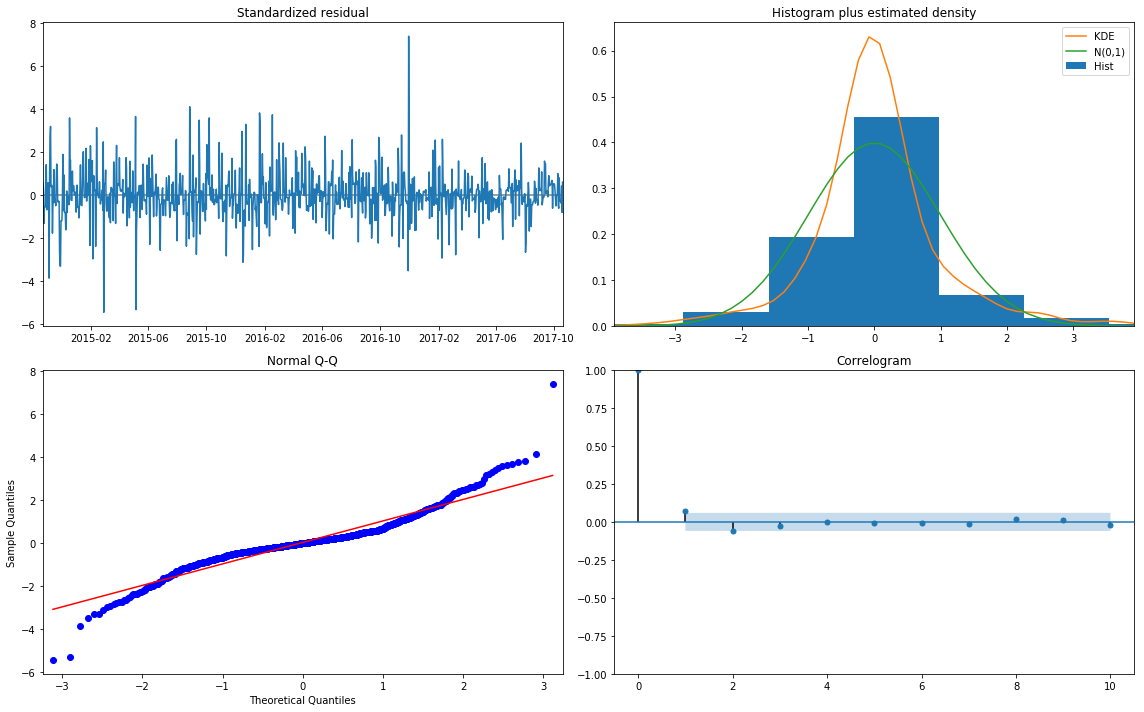

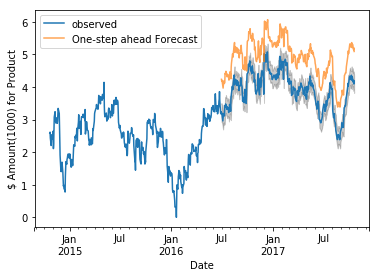

The Mean Squared Error of our forecasts is 0.84


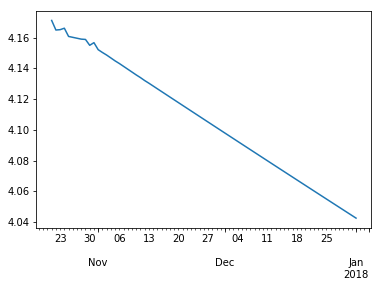

Forcasted $ Values for product  104 are : 2017-10-21    4.171181
2017-10-22    4.164945
2017-10-23    4.165174
2017-10-24    4.166124
2017-10-25    4.160769
Freq: D, dtype: float64




Stats for product 236
Best (1, 0, 0),(1, 0, 0, 12),-1707.981449040422490404226


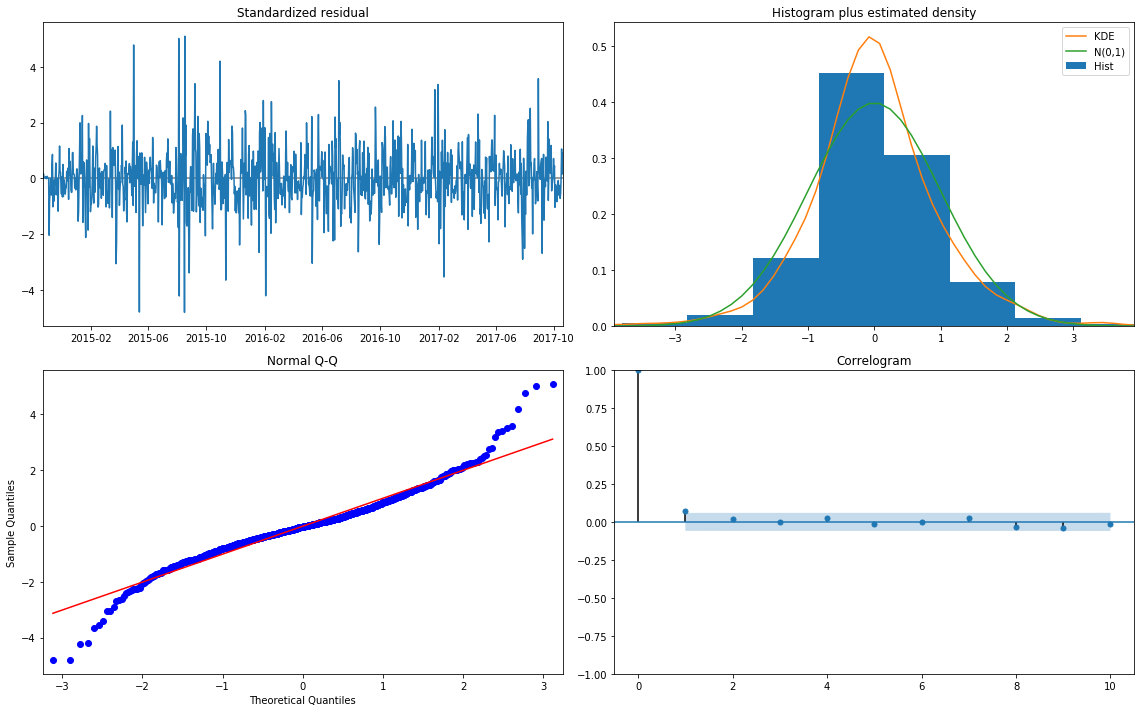

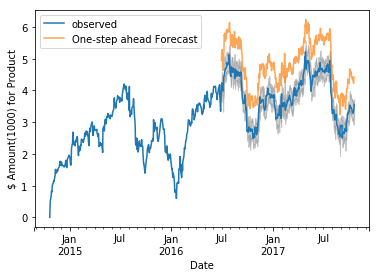

The Mean Squared Error of our forecasts is 0.74


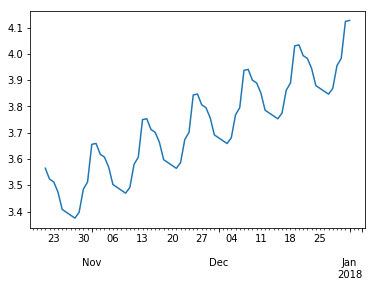

Forcasted $ Values for product  236 are : 2017-10-21    3.564857
2017-10-22    3.523554
2017-10-23    3.512538
2017-10-24    3.473988
2017-10-25    3.407906
Freq: D, dtype: float64






In [31]:
forcast=[]
result=[]
bestparam=[]
bestparam_seasonal=[]
pred=[]
for m in columns:
    try:
        temp=data[["index",m]]
        temp=temp.set_index("index")
        y=temp[m]
        print("Stats for product",m)
        bestparam, bestparam_seasonal= FindBestParameters(y)
        result=model(bestparam,bestparam_seasonal)
        pred=fit(result)
        forcast=predict(pred,result,y)
        print("Forcasted $ Values for product ",m,'are :',forcast.head())
        print("\n\n\n")
    except:
        continue
    

## Automation for each and any product

Just run the below block, it will ask you to enter the product for which you would want to see the forcasted values.

Choose the product for which you want to see the forcast ?35
Best (1, 0, 0),(1, 0, 0, 12),-1637.129419009865190098655


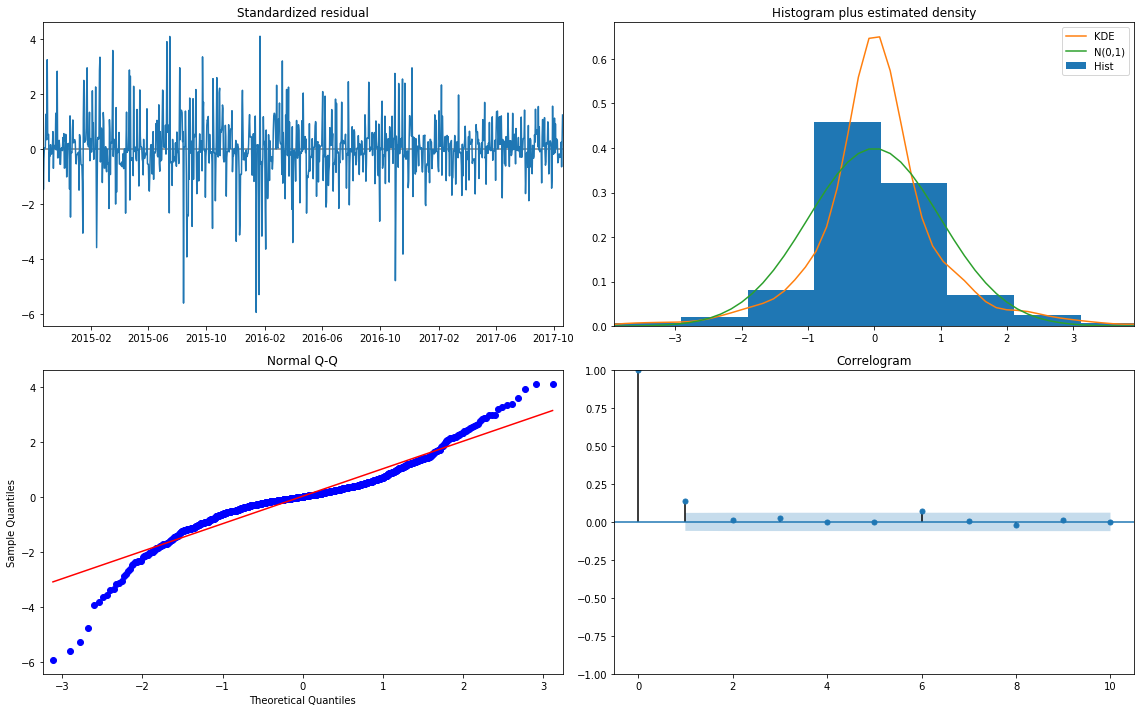

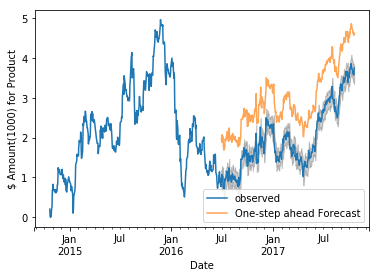

The Mean Squared Error of our forecasts is 0.74


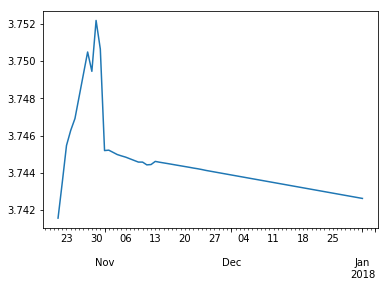

Forcasted $ Values for product  35  are:  2017-10-21    3.741567
2017-10-22    3.743484
2017-10-23    3.745472
2017-10-24    3.746285
2017-10-25    3.746919
Freq: D, dtype: float64



Compare ARIMA with RNN(incase ARIMA doesnt work we use RNN) and also see how closely the actual vs predicted price varies
528
226


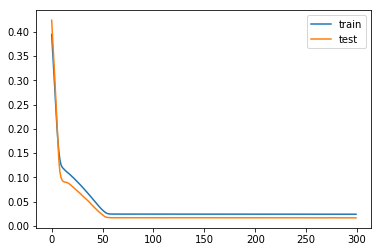

Test MSE: 0.011


In [32]:
product = input("Choose the product for which you want to see the forcast ?")
for i in range(1,2):
    try:
        temp=df_2[["index",product]]
        temp=temp.set_index("index")
        y=temp[product]
        bestparam, bestparam_seasonal= FindBestParameters(y)
        result=model(bestparam,bestparam_seasonal)
        pred=fit(result)
        forcast=predict(pred,result,y)
        print("Forcasted $ Values for product ",product," are: ",forcast.head())
    except:
        print("Wrong Product or series is not yet stationary, increase p,q,d range in FindBestParameters() function for more processing")
    print("\n\n\nCompare ARIMA with RNN(incase ARIMA doesnt work we use RNN) and also see how closely the actual vs predicted price varies")
    train,test,scaler=getdata(product)
    trainX,testX,trainY,testY=reshape_data(train,test)
    history,model=NN_model(trainX,testX)
    yhat=plotTrain_Test(history,model)
    yhat_inverse,testY_inverse=FindMSE(yhat,testY,scaler)
    ActualvsPredicted(testX,yhat_inverse,testY_inverse)


# Result

We were successful in calculating/ forcasting values of each and any product for the entire year of 2017 with S-ARIMA. Our MSE is decent, hence we can say that our actual values would fall somewhere around these forcasted values. 

We can furture implement RNN or LSTM using KERAs or TensorFLow to further improve our aacuracy.

Thank you for the challenge, due to my exams and time restraints, **I made a simple inclusion of RNN model to see how it performs against my ARIMA model, but coulndt complete it for forcasting**. 

I tried to do my best to with what ever time I had, would have definately loved to see and compare the results I would have got from RNN/LSTM model.